In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 7.0]
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import FunctionTransformer

from load_utils import load_data
from features import mean_of_var, wind_speed, wind_direction, all_features, k_diff
from CAPE_CNR_metric import CAPE_CNR_function
from models.sk_model import *
from models.lstm_models import *

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



## Train set

In [511]:
df, target = load_data()
true_prod = target.stack('WF')['Production']

In [512]:
features = all_features(df, get_diff=[1, 2, 3], test_set=True)

full_df = pd.concat([features, target], axis=1)

full_df_wfs = list(map(lambda df: df.drop('Production', axis=1), split_data_wf(full_df)))

In [513]:
prod_df_wfs = list(map(lambda features_df: features_df['Production'], split_data_wf(full_df)))
prod_wfs = list(map(lambda df: df.to_numpy(), prod_df_wfs))

In [516]:
def get_CAPE(true_prod, model_pred):
    """ Compute CAPE loss with comparable datasets (remove NaN and keep common indices) """
    true_prod_model = true_prod[model_pred.index]                  
    true_prod_model = true_prod_model[~true_prod_model.isna()]     
    model_pred_final = model_pred[true_prod_model.index]
    return CAPE_CNR_function(true_prod_model.values, model_pred_final.values)

### Sk model

#### Train regressor

In [514]:
model = SGDRegressor
parameters = dict(loss='huber', penalty='l2', alpha=0.0001,
                  fit_intercept=True, max_iter=200, tol=0.001,)
parameters = {f"model__{k}": [v] for k, v in parameters.items()}

# model = MLPRegressor
# parameters = {'model__alpha': 10.0 ** np.arange(-5, -4),
#                'model__hidden_layer_sizes': [(100,) * i for i in range(1, 2)]}

sk_regressor_full = SkRegressorIndividual(model, parameters)
sk_regressor_full.fit(full_df)

[W 200324 02:51:55 sk_model:84] Some target values are Nan! Removing specific lines...
[I 200324 02:51:55 sk_model:210] Fit on WF 1
[I 200324 02:51:55 sk_model:228] score on test = 48.81
[D 200324 02:51:55 sk_model:229] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200324 02:51:55 sk_model:210] Fit on WF 2
[I 200324 02:51:55 sk_model:228] score on test = 35.11
[D 200324 02:51:55 sk_model:229] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200324 02:51:55 sk_model:210] Fit on WF 3
[I 200324 02:51:56 sk_model:228] score on test = 34.71
[D 200324 02:51:56 sk_model:229] {'model__alpha': 0.0001, 'model__fit_intercept': True, 'model__loss': 'huber', 'model__max_iter': 200, 'model__penalty': 'l2', 'model__tol': 0.001}
[I 200324 02:51:56 sk_model:210] Fit on WF 4
[I 200324 02:51:56 sk_mod

#### Make predictions

In [515]:
sk_predictions = sk_regressor_full.predict(full_df)

In [517]:
sk_predictions

Time                 WF
2018-05-05 00:00:00  1     0.224215
                     2     2.801654
                     3     3.045500
                     4     1.139372
                     5     1.137718
                             ...   
2019-01-15 23:00:00  2     0.202586
                     3     1.752634
                     4     1.550494
                     5     1.746342
                     6     0.336621
Length: 31242, dtype: float64

In [536]:
print("Sk model prediction score: {:.2f}".format(get_CAPE(true_prod, sk_predictions)))

Sk model prediction score: 37.99


In [539]:
sk_predictions_unstack = sk_predictions.unstack('WF')
sk_predictions_unstack.head()

WF                          1         2         3         4         5  \
Time                                                                    
2018-05-05 00:00:00  0.224215  2.801654  3.045500  1.139372  1.137718   
2018-05-05 01:00:00  0.115641  2.568122  3.236843  1.306553  0.698995   
2018-05-05 02:00:00  0.022794  2.528068  3.525331  1.410959  0.551959   
2018-05-05 03:00:00  0.026970  2.786721  3.745086  1.373417  0.632863   
2018-05-05 04:00:00  0.000000  2.805053  3.843412  1.322989  0.607216   

WF                          6  
Time                           
2018-05-05 00:00:00  1.126152  
2018-05-05 01:00:00  1.119702  
2018-05-05 02:00:00  1.035314  
2018-05-05 03:00:00  0.827763  
2018-05-05 04:00:00  0.752681

### LSTM

In [543]:
features = all_features(df, get_diff=[], test_set=True) # no diff to compute

full_df = pd.concat([features, target], axis=1)

#### Load model

In [544]:
lstm_regressor = LstmRegressor({}, shift=12, id="mean_12")

#### Make predictions

In [545]:
lstm_predictions = lstm_regressor.predict(full_df)

In [546]:
prod_wfs_cape = np.vstack(prod_wfs).flatten('F')
lstm_predictions_cape = np.vstack(lstm_predictions).flatten('F')
lstm_predictions_cape = lstm_predictions_cape[~np.isnan(prod_wfs_cape)]
prod_wfs_cape = prod_wfs_cape[~np.isnan(prod_wfs_cape)]

In [549]:
print("LSTM model prediction score: {:.2f}".format(CAPE_CNR_function(prod_wfs_cape, lstm_predictions_cape)))

LSTM model prediction score: 40.38


### Compare on train

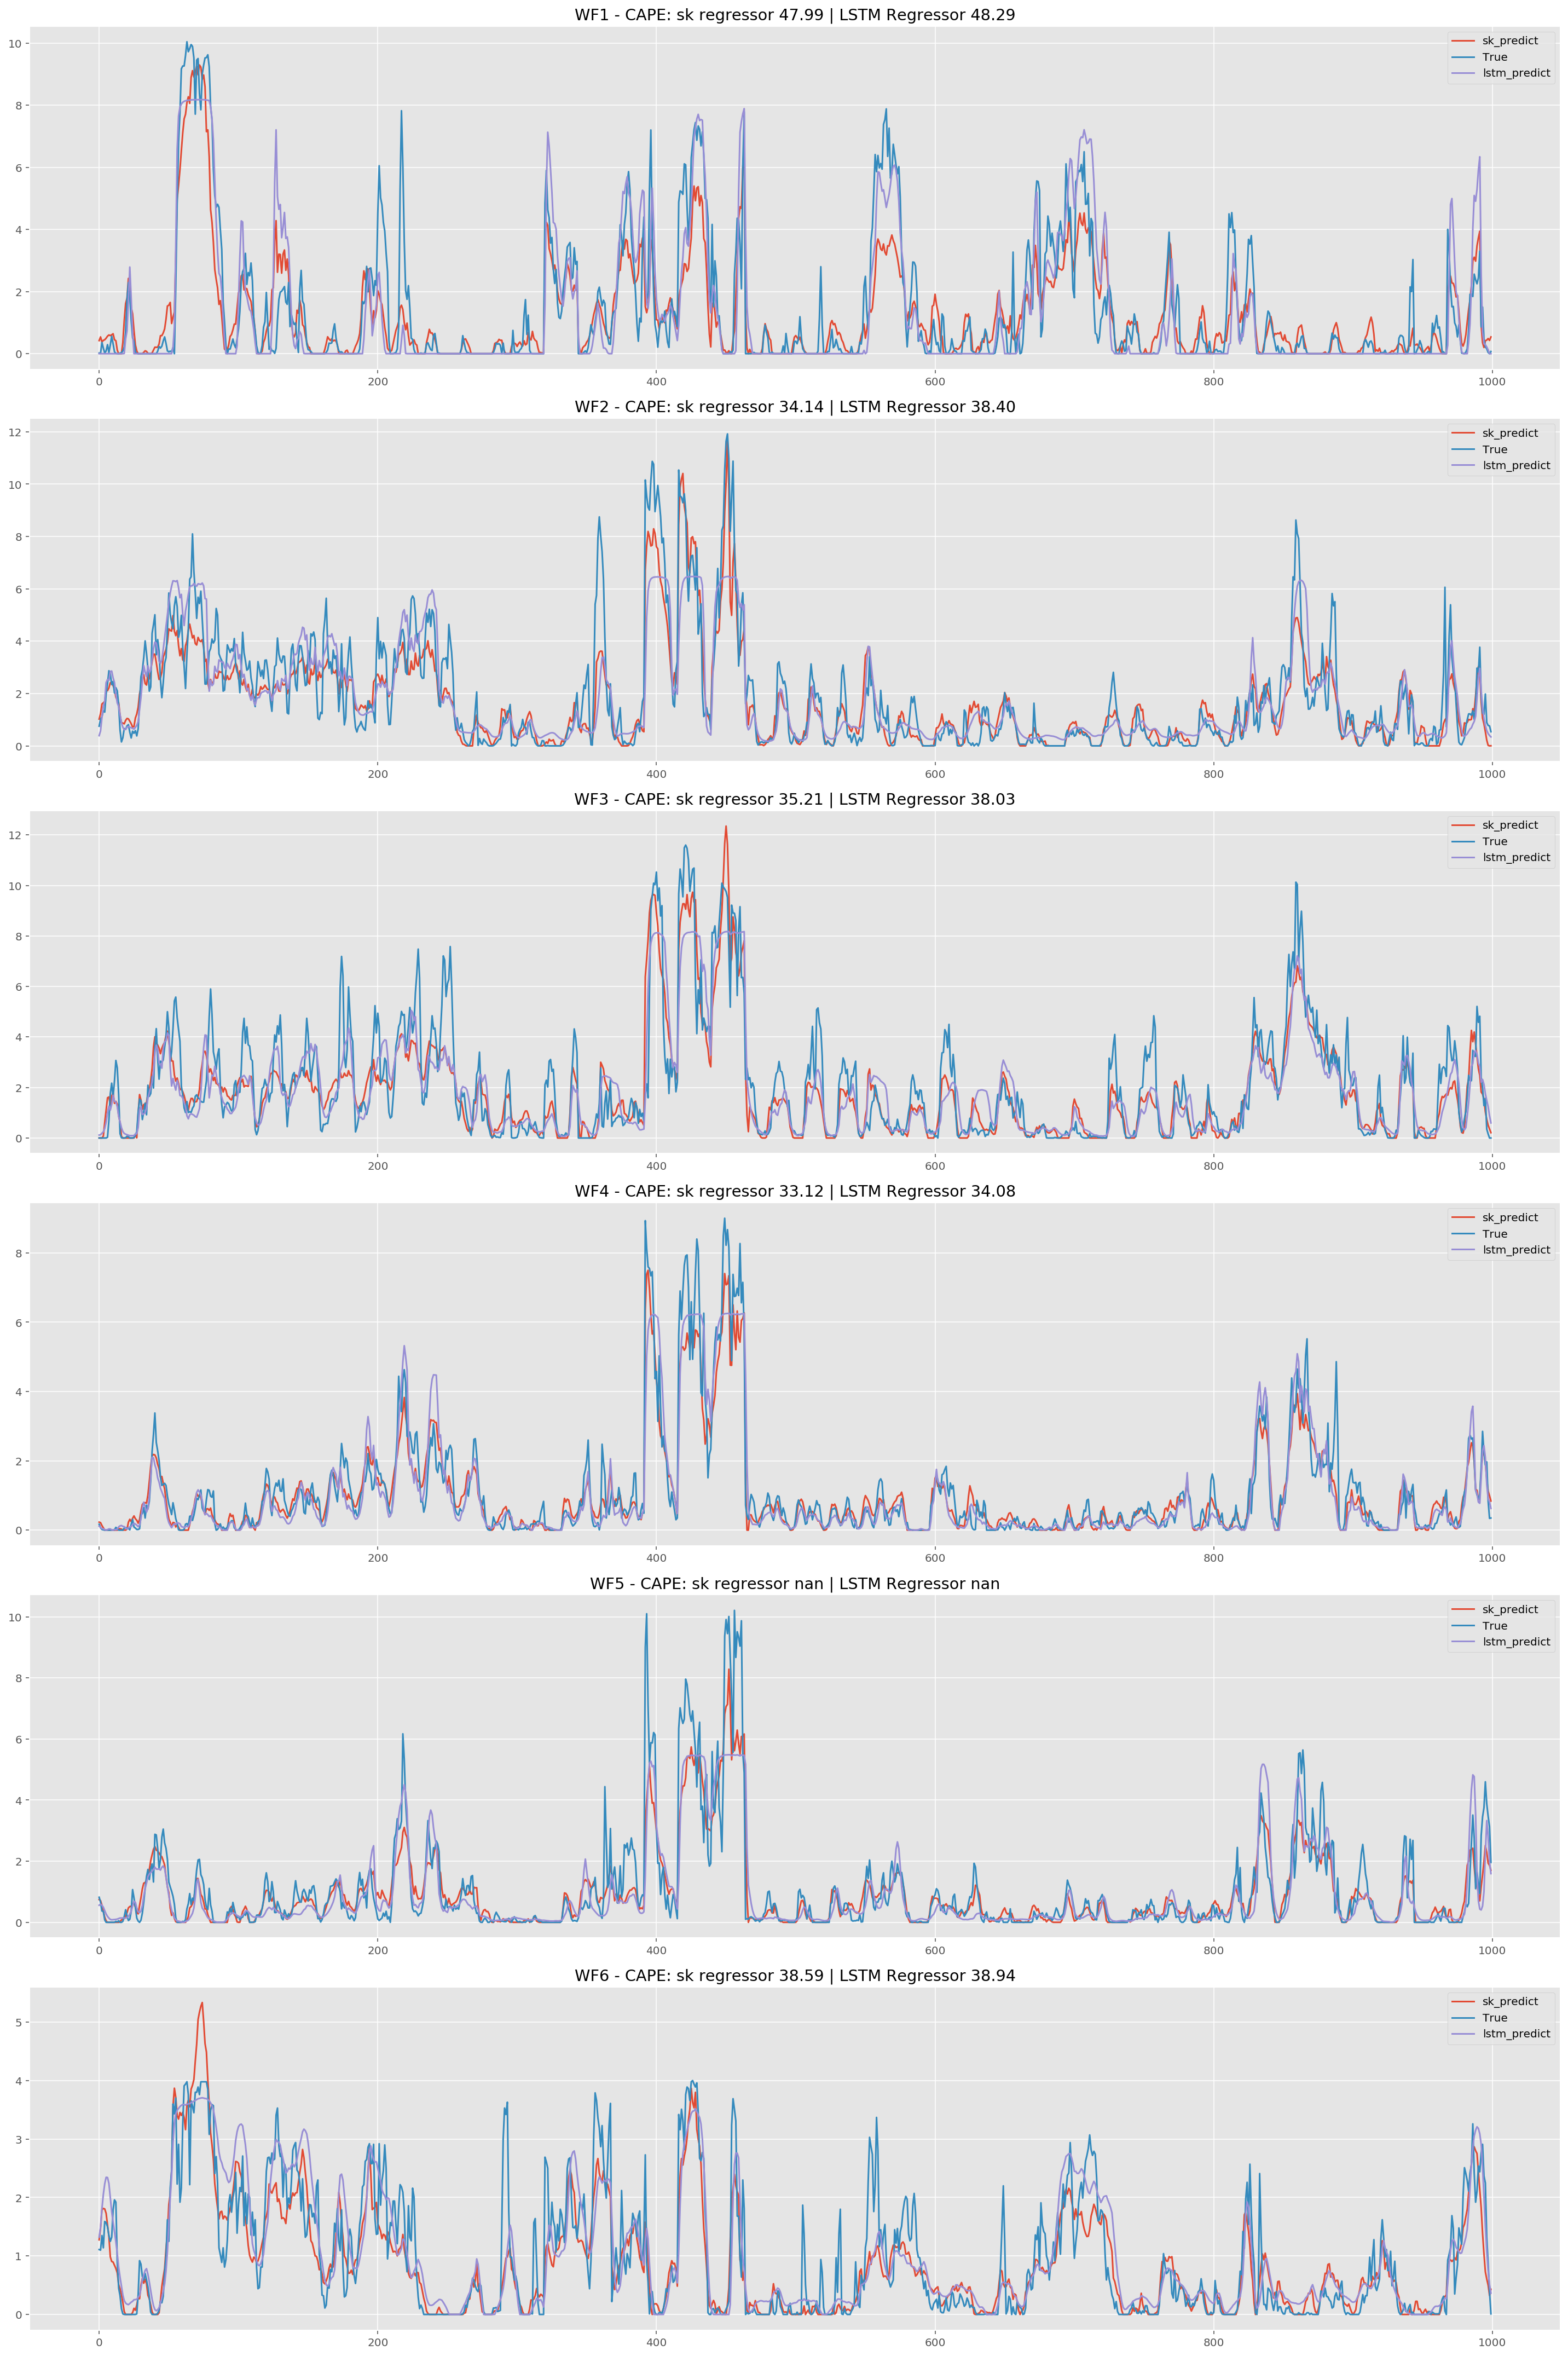

In [551]:
window = slice(1000, 2000)
fig, axes = plt.subplots(6, 1, figsize = (20, 5 * 6))
for i, ax in enumerate(axes):
    ax.plot(sk_predictions_unstack[i+ 1].values[window], label='sk_predict')
    ax.plot(prod_wfs[i][window], label='True')
    ax.plot(lstm_predictions[i][window], label='lstm_predict')
    ax.legend()
    ax.set_title(f"WF{i + 1} - CAPE: sk regressor {CAPE_CNR_function(prod_wfs[i], sk_predictions_unstack[i + 1]):.2f} | LSTM Regressor {CAPE_CNR_function(prod_wfs[i], lstm_predictions[i]):.2f}")
plt.tight_layout()

fig.savefig('images/train_predictions.png')

plt.show()

## On test

#### load test sets

In [554]:
df_test = load_data('data/X_test_v2.csv', path_Y=None, crop_train_period=False)
random_y = pd.read_csv('data/Y_test_random.csv')

# Brut data - will be used for submissions
brut_test = pd.read_csv('data/X_test_v2.csv')
brut_test.index = brut_test['ID']
brut_test = brut_test[['Time', 'WF']]
brut_test['Time'] = pd.to_datetime(brut_test['Time'])
brut_set_index = set()
for couple in brut_test[['Time', 'WF']].values:
    brut_set_index.add((couple[0], couple[1]))

### Make predictions
#### Sk model

In [555]:
features_test_sk = all_features(df_test, get_diff=[1, 2, 3], test_set=True)

In [573]:
test_predictions_sk = sk_regressor_full.predict(features_test_sk)
test_predictions_sk_unstack = test_predictions_sk.unstack('WF')

#### /!\ Submission format /!\

In [556]:
# should be stacked like this:
test_predictions_sk

Time                 WF
2019-01-02 00:00:00  1     3.726205
                     2     3.539296
                     3     4.244137
                     4     2.534133
                     5     2.529574
                             ...   
2019-12-09 23:00:00  2     1.341147
                     3     0.675194
                     4     0.734979
                     5     1.061396
                     6     0.446304
Length: 37158, dtype: float64

In [557]:
def make_submission(stacked_pred, brut_df, brut_df_set_index):
    """ Take stacked predictions (stacked_pred) and return a DataFrame with good indices (reference for indices being found in brut_df) """
    pred_ = []
    ind = []
    for time, wf in tqdm(stacked_pred.index):
        wff = 'WF' + str(wf)
        if (time, wff) in brut_df_set_index:
            pred_.append(stacked_pred[(time, wf)])
            ind.append(brut_df[(brut_df.Time == time) & (brut_df.WF == wff)].index[0])
            
    pred_ = np.array(pred_)
    ind = np.array(ind)
    aux = np.argsort(ind)
    pred_ = pred_[aux]
    ind = ind[aux]
    
    pred_ = pd.DataFrame( pred_, columns=['Production'], index=ind)

    pred_.index = pred_.index.astype('int')
    return pred_

In [558]:
sk_df_sub = make_submission(test_predictions_sk, brut_test, brut_set_index)




  0%|          | 0/37158 [00:00<?, ?it/s]


  0%|          | 34/37158 [00:00<01:50, 336.35it/s]


  0%|          | 69/37158 [00:00<01:49, 340.05it/s]


  0%|          | 107/37158 [00:00<01:46, 348.69it/s]


  0%|          | 140/37158 [00:00<01:48, 342.58it/s]


  0%|          | 174/37158 [00:00<01:48, 339.52it/s]


  1%|          | 208/37158 [00:00<01:49, 337.99it/s]


  1%|          | 242/37158 [00:00<01:49, 338.29it/s]


  1%|          | 276/37158 [00:00<01:49, 337.12it/s]


  1%|          | 311/37158 [00:00<01:48, 338.76it/s]


  1%|          | 346/37158 [00:01<01:48, 339.18it/s]


  1%|          | 382/37158 [00:01<01:47, 342.97it/s]


  1%|          | 416/37158 [00:01<01:47, 340.22it/s]


  1%|          | 451/37158 [00:01<01:47, 342.75it/s]


  1%|▏         | 486/37158 [00:01<01:46, 344.13it/s]


  1%|▏         | 523/37158 [00:01<01:44, 350.82it/s]


  2%|▏         | 560/37158 [00:01<01:42, 356.02it/s]


  2%|▏         | 601/37158 [00:01<01:39, 369.23it/s]


  2%|▏         | 646

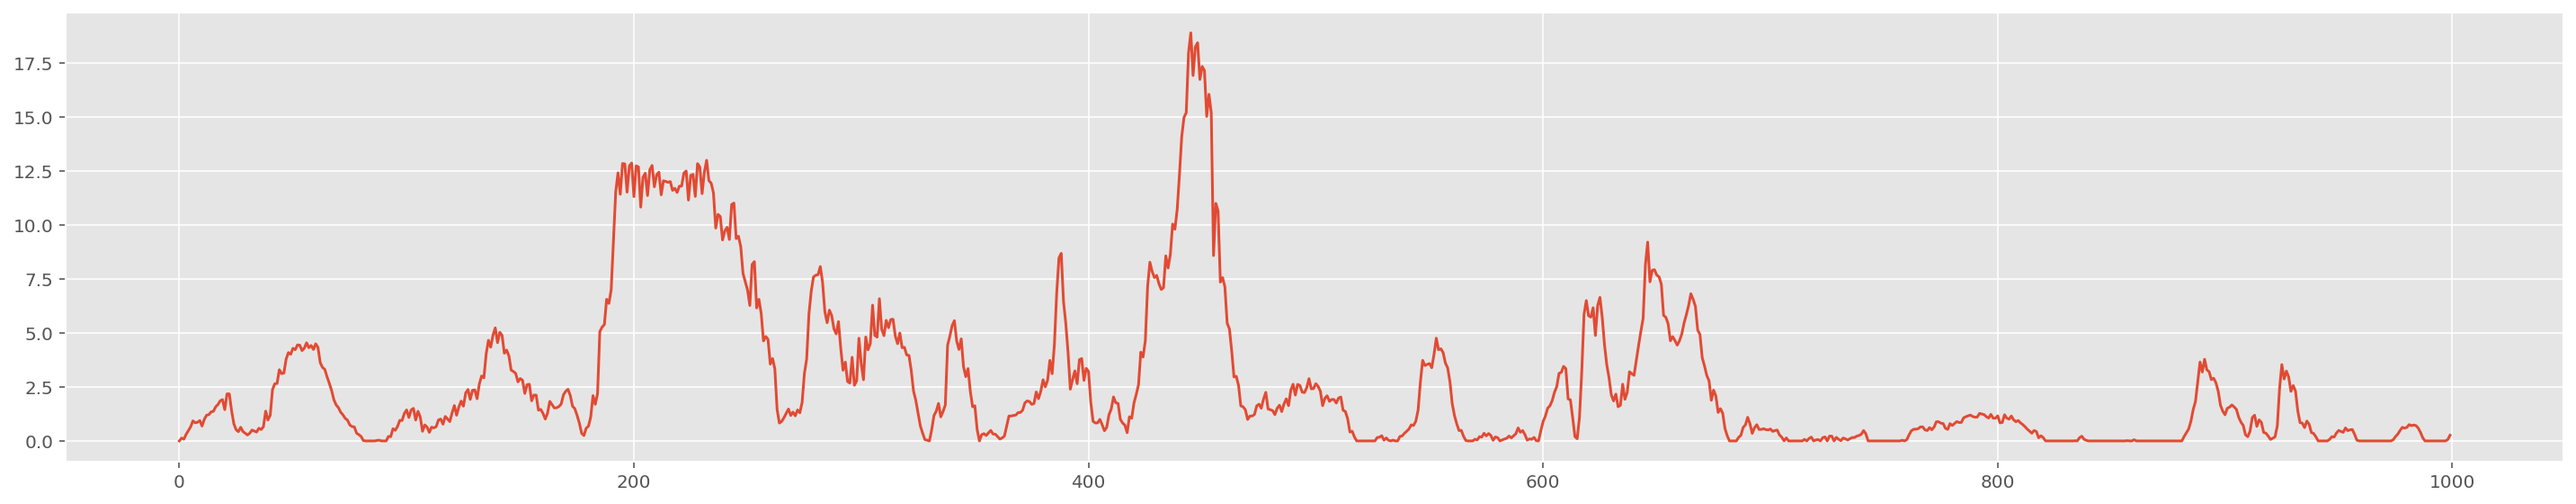

In [562]:
# should look good (sufficiently smooth)
plt.figure(figsize=(20, 4))
plt.plot(sk_df_sub.values[:1000])
plt.tight_layout()
plt.show()

##### Save submission

In [563]:
if np.all(sk_df_sub.index == random_y.ID):
    sk_df_sub.to_csv('test_sk.csv')
    print("saved")
else:
    print('A problem happened')

saved


#### LSTM model

In [564]:
features_test_lstm = all_features(df_test, get_diff=[], test_set=True)

In [565]:
test_predictions_lstm = lstm_regressor.predict(features_test_lstm)

In [566]:
test_predictions_lstm # one list corresponding to each WF

[array([3.615557, 4.6736  , 6.282895, ..., 0.      , 0.      , 0.      ],
       dtype=float32),
 array([2.2734122, 2.6284182, 2.774756 , ..., 1.11454  , 1.2000425,
        1.2129325], dtype=float32),
 array([2.4901795 , 4.421315  , 5.6342735 , ..., 0.41040224, 0.4419216 ,
        0.52432996], dtype=float32),
 array([2.2636404 , 3.5133002 , 3.5317068 , ..., 0.46015435, 0.49065158,
        0.499047  ], dtype=float32),
 array([1.274703  , 1.8745409 , 2.343246  , ..., 0.79983646, 0.7554215 ,
        0.7519148 ], dtype=float32),
 array([1.4452279 , 2.1314619 , 2.4436507 , ..., 0.58048505, 0.48221484,
        0.416156  ], dtype=float32)]

In [569]:
aux_lstm_test = features_test_lstm.stack('WF')
aux_lstm_test["Production"] = np.vstack(test_predictions_lstm).flatten("F")
aux_lstm_test = aux_lstm_test['Production']
aux_lstm_test # stacked data

Time                 WF
2019-01-02 00:00:00  1     3.615557
                     2     2.273412
                     3     2.490180
                     4     2.263640
                     5     1.274703
                             ...   
2019-12-09 23:00:00  2     1.212932
                     3     0.524330
                     4     0.499047
                     5     0.751915
                     6     0.416156
Name: Production, Length: 37158, dtype: float32

In [504]:
lstm_df_test_sub = make_submission(aux_lstm_test, brut_test, brut_set_index)




  0%|          | 0/37158 [00:00<?, ?it/s]


  0%|          | 1/37158 [00:00<1:15:58,  8.15it/s]


  0%|          | 38/37158 [00:00<53:38, 11.53it/s] 


  0%|          | 75/37158 [00:00<38:01, 16.26it/s]


  0%|          | 112/37158 [00:00<27:05, 22.79it/s]


  0%|          | 150/37158 [00:00<19:26, 31.73it/s]


  1%|          | 188/37158 [00:00<14:05, 43.74it/s]


  1%|          | 226/37158 [00:00<10:20, 59.51it/s]


  1%|          | 264/37158 [00:00<07:43, 79.58it/s]


  1%|          | 301/37158 [00:00<05:54, 103.97it/s]


  1%|          | 337/37158 [00:01<04:38, 132.01it/s]


  1%|          | 373/37158 [00:01<03:47, 161.38it/s]


  1%|          | 408/37158 [00:01<03:12, 191.14it/s]


  1%|          | 443/37158 [00:01<02:47, 219.43it/s]


  1%|▏         | 478/37158 [00:01<02:28, 246.34it/s]


  1%|▏         | 513/37158 [00:01<02:15, 269.48it/s]


  1%|▏         | 549/37158 [00:01<02:06, 289.59it/s]


  2%|▏         | 585/37158 [00:01<01:59, 305.86it/s]


  2%|▏         | 627/37158 

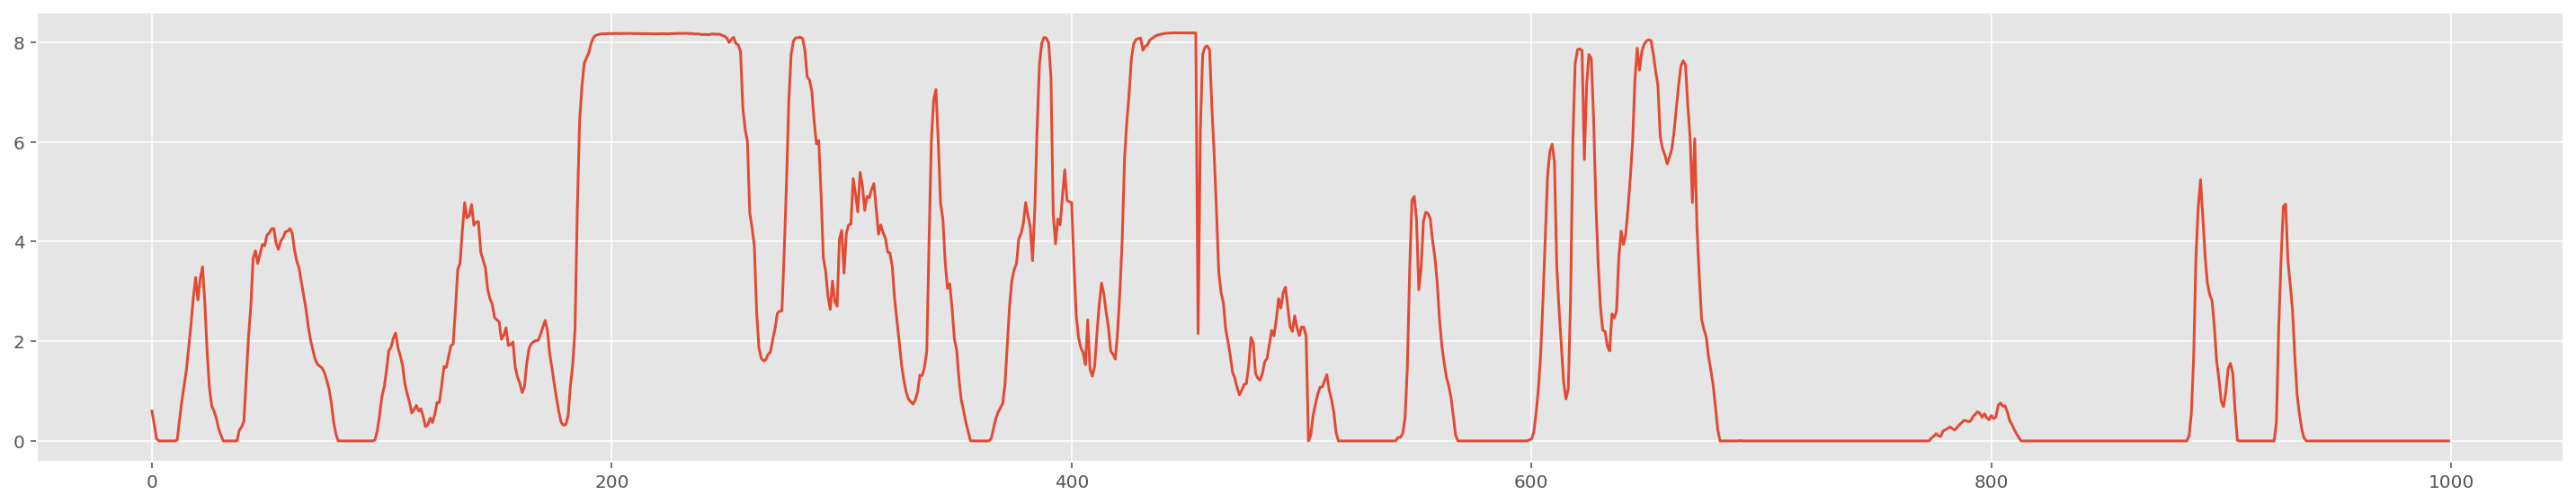

In [570]:
# should look good (sufficiently smooth)
plt.figure(figsize=(20, 4))
plt.plot(lstm_df_test_sub.values[:1000])
plt.tight_layout()
plt.show()

##### Save submission

In [571]:
if np.all(pred_sk_test_df.index == random_y.ID):
    lstm_df_test_sub.to_csv('test_lstm.csv')
    print("saved")
else:
    print('A problem happened')

saved


#### Compare on test

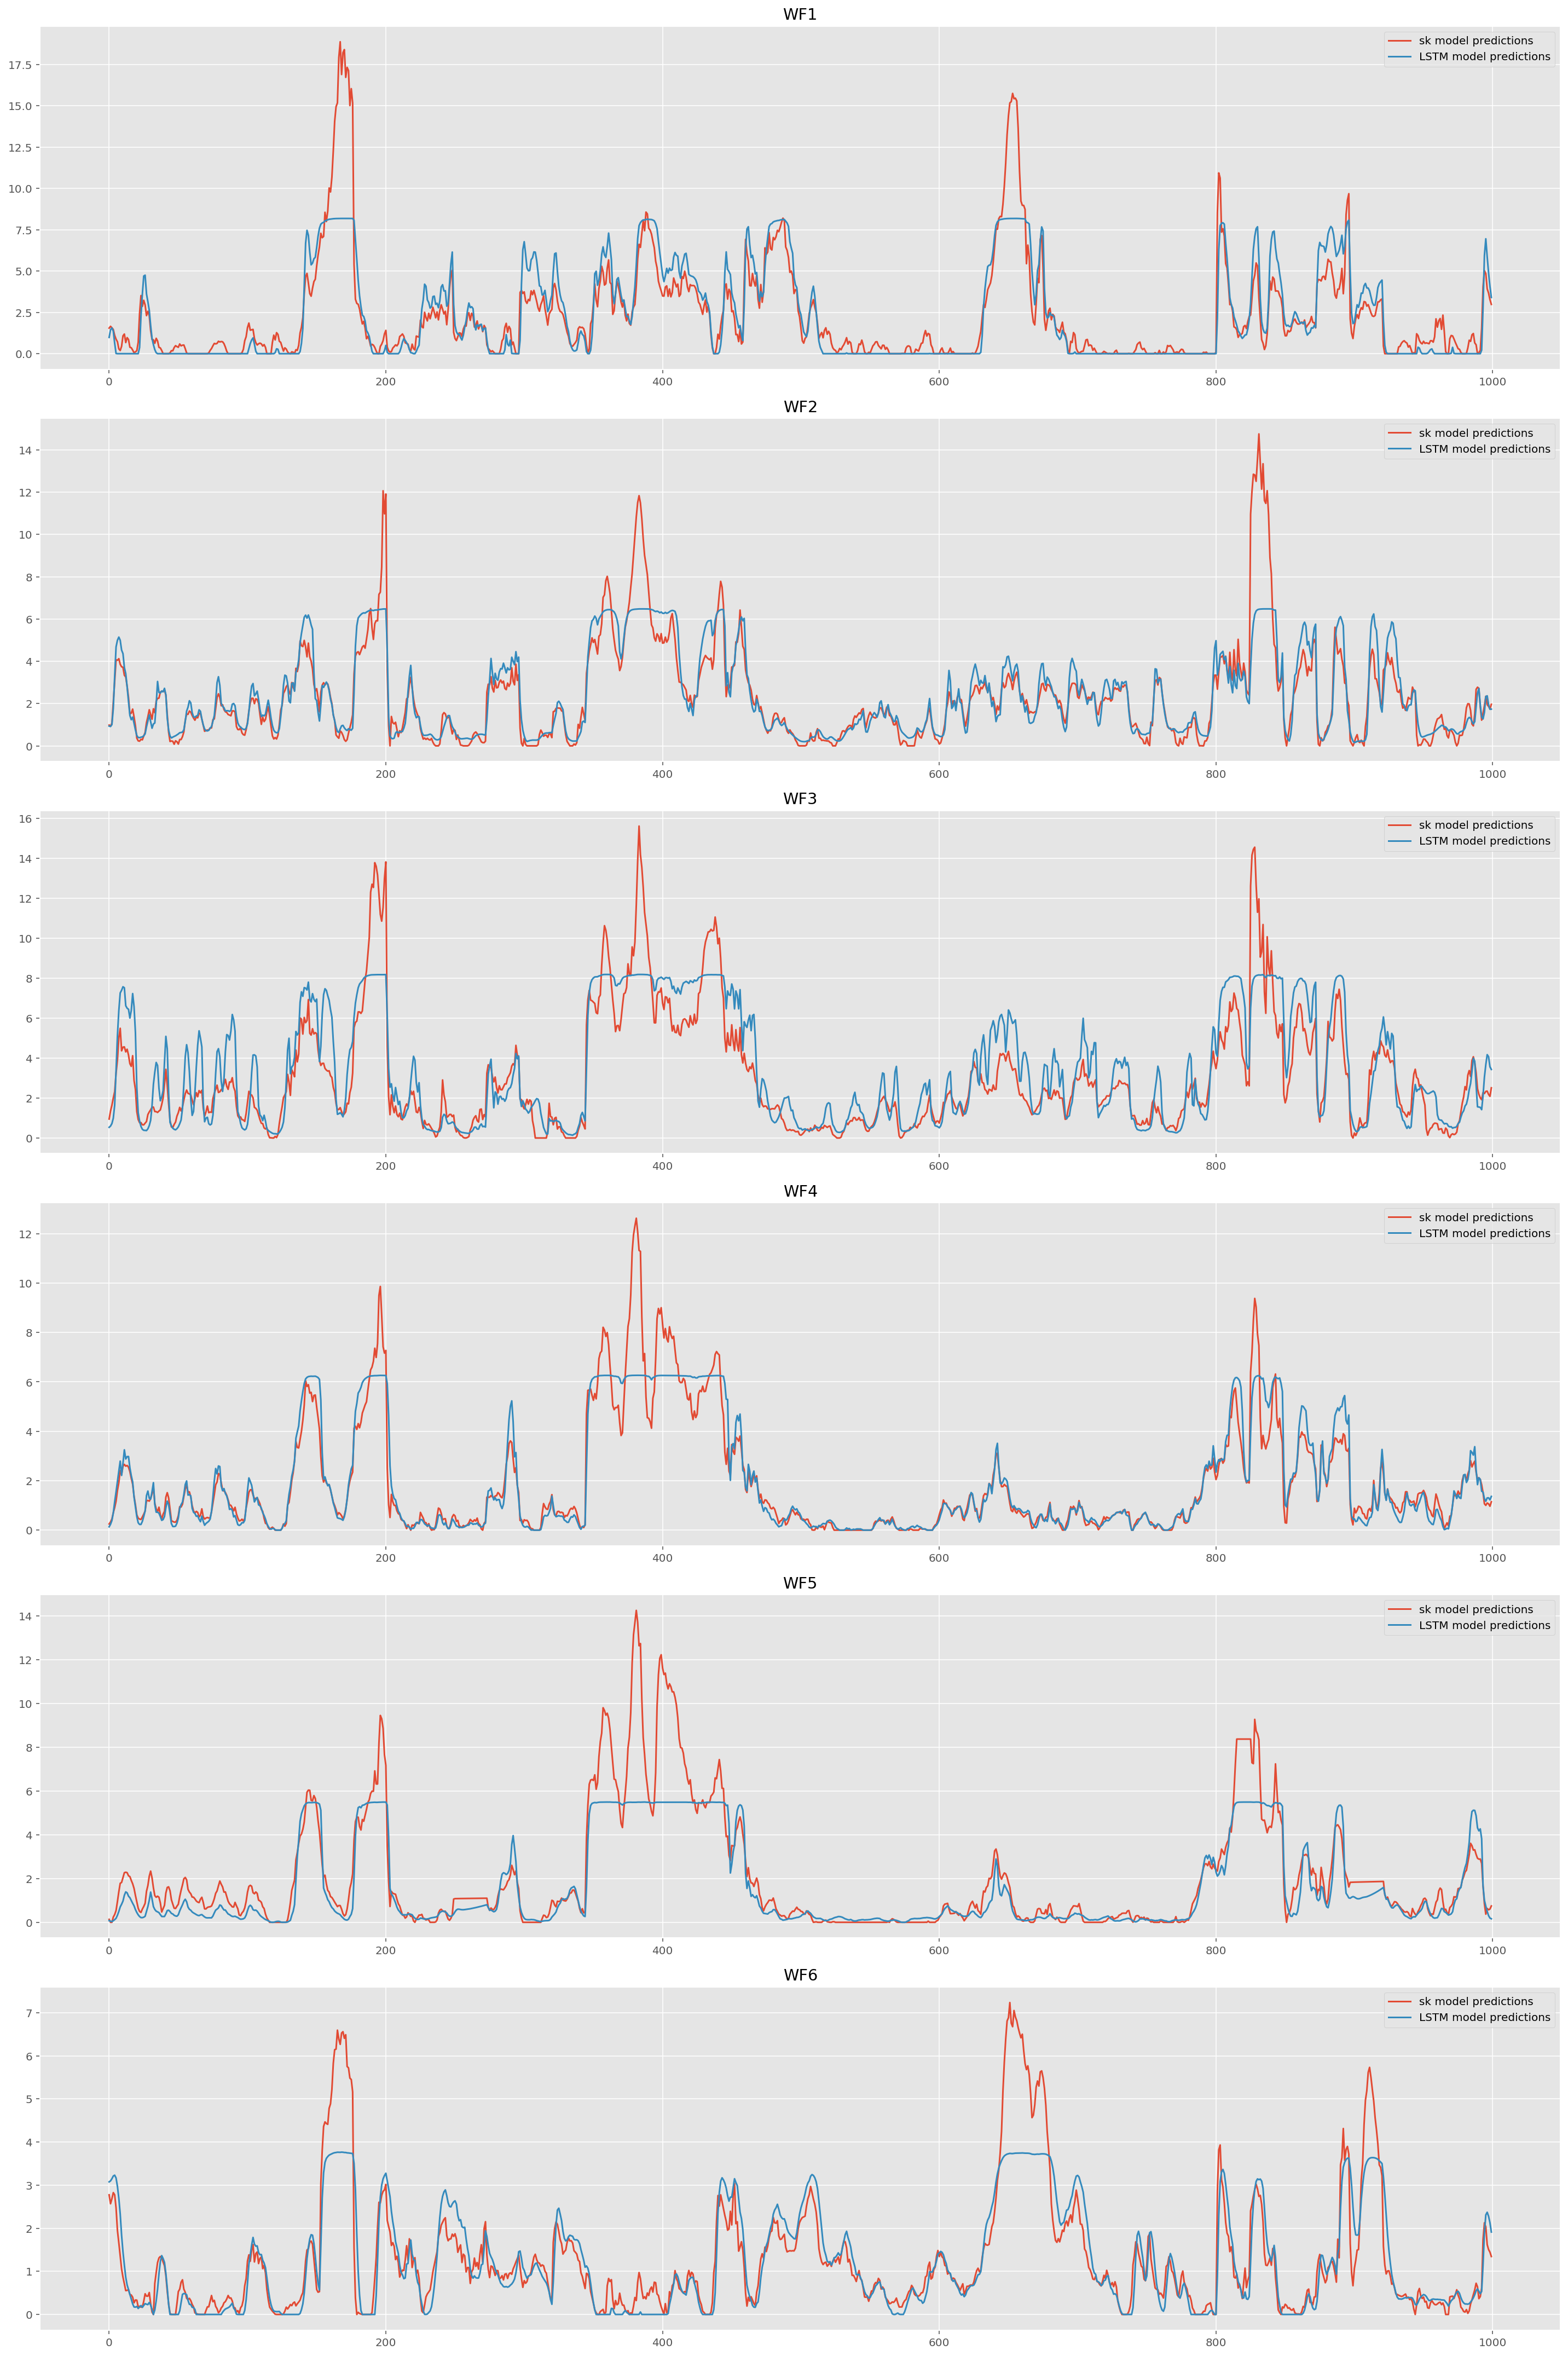

In [574]:
window = slice(1000, 2000)
fig, axes = plt.subplots(6, 1, figsize = (20, 5 * 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(test_predictions_sk_unstack[i + 1].values[window], label='sk model predictions')
    ax.plot(test_predictions_lstm[i][window], label='LSTM model predictions')
    ax.legend()
    ax.set_title(f'WF{i + 1}')
plt.tight_layout()
fig.savefig('images/test_predictions.png')
plt.show()